# Data Mining - Homework #1 | 

# Table of contents

>[Data Mining - Homework #1 | ](#scrollTo=AIydB0wBNbif)





>[Table of contents](#scrollTo=OYXTkpNHTCzK)

>[Prerequisites](#scrollTo=YW0fEGk8TIQx)

>>[Imports](#scrollTo=0SysH3n_Ngsh)

>>[Load Dataset](#scrollTo=Y1l_Gc_SNJNa)

>>>[Describe the dataset](#scrollTo=jYGZvK_SQlnC)

>>>[Print some rows](#scrollTo=Fy6uAbNQRK25)

>>>[Histograms](#scrollTo=uBIEvKvmlO33)

>[Feature extraction](#scrollTo=tBrLyUkfxPrh)

>>[Useless features](#scrollTo=65MuBLTV3g7Z)

>>[Missing values](#scrollTo=-Fy9s3sylbLK)

>>[Syntetic features](#scrollTo=cM7mNb7-kzsF)

>>[Code](#scrollTo=A46EYe62l3HV)

>[Evaluation setup](#scrollTo=MiNoC3vzw2MX)

>>[Setting up an evaluation config](#scrollTo=om8LADbl3Eed)

>>[Plotting](#scrollTo=v3bP290-FYJ_)

>[Evaluating & comparing classifiers](#scrollTo=SF44dmeF4vjI)

>>[Logistic regression](#scrollTo=bsaLCLvLH_nL)

>>[Random forests](#scrollTo=nIyx0w86bS9_)

>>[K-Nearest Neighbors](#scrollTo=NNcy6vhhHAkK)

>>[Keeping the best](#scrollTo=MgvJUwAqHUFW)

>[Evaluating & comparing regressors](#scrollTo=gcX5Lp8ev7Vr)

>>[Linear regression](#scrollTo=GzekaGC3v7Vr)

>>[K-Nearest Neighbors Regression](#scrollTo=z6hY3s2_4XDp)

>>[Keeping the best](#scrollTo=xmUPX2GH1i8S)

>>[Visualizing regression curves](#scrollTo=GItsC1FxBmdY)



# Prerequisites

## Imports

In [0]:
import pandas as pd
import sklearn as sk
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display

# Models for classification.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Models for regression.
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

# Make random reproducible.
np.random.seed(0)

## Load Dataset

Load the training dataset .csv file.

In [0]:
df = pd.read_csv("dataset.csv")

In [0]:
numerical_columns = [
    'Weight(g)',
    'Height(cm)',
    'Longevity(yrs)',
]
categorical_columns = [
    'Breed Name',
    'Energy level', 
    'Attention Needs', 
    'Coat Lenght', 
    'Sex', 
    'Owner Name',
]

### Describe the dataset

Print useful statistics about the dataset.

In [0]:
df[numerical_columns].describe()

,Weight(g),Height(cm),Longevity(yrs)
count,1000.000000,817.000000,1000.000000
mean,23317.861289,48.045748,12.359492
std,18302.502780,15.866352,1.573533
min,2377.710600,29.829600,9.281400
25%,5528.127400,32.557600,11.002500
50%,26924.950300,57.908400,12.070750
75%,37483.457125,63.653300,13.831850
max,76371.811800,70.231200,16.126900


In [0]:
df[categorical_columns].describe()

,Breed Name,Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
count,1000,1000,1000,1000,1000,1000
unique,4,3,3,3,2,505
top,German Shepherd,med,med,med,male,Smith
freq,271,606,623,618,501,20


### Print some rows

Print the first 5 rows of the dataframe.

In [0]:
display(df[:5])

,Breed Name,Weight(g),Height(cm),Longevity(yrs),Energy level,Attention Needs,Coat Lenght,Sex,Owner Name
0,Jack Russel Terrier,5078.5216,NaN,13.0365,high,med,short,female,Hernandez
1,Bichon Frise,6514.2899,29.9725,15.4064,med,high,med,female,Fuller
2,Bichon Frise,5340.1420,30.0039,13.6421,med,high,med,male,Bowen
3,Akita,32090.3353,66.1419,11.4628,low,med,short,female,Roach
4,German Shepherd,37030.1834,NaN,11.2622,high,high,med,male,Huang


### Histograms
Print histograms and bar charts, to better understand the data.

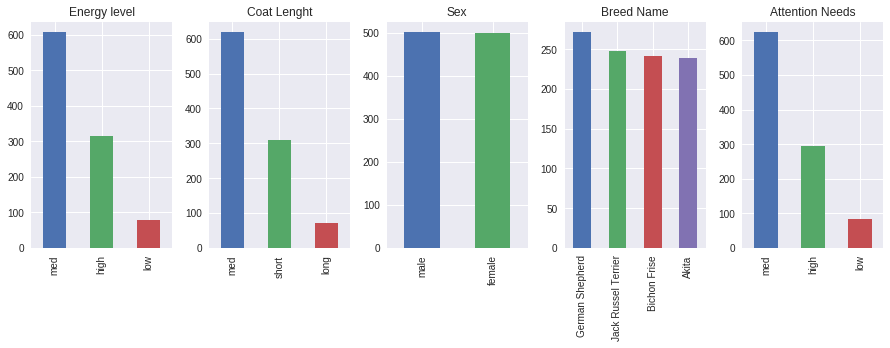

In [0]:
# Histograms for categorical data.
plt.figure(figsize=(15,5))
for idx, column in enumerate(set(categorical_columns) - set(['Owner Name'])):
  plt.subplot(1, len(categorical_columns), idx + 1)
  plt.title(column)
  df[column].value_counts().plot(kind='bar')
plt.tight_layout()
plt.show()

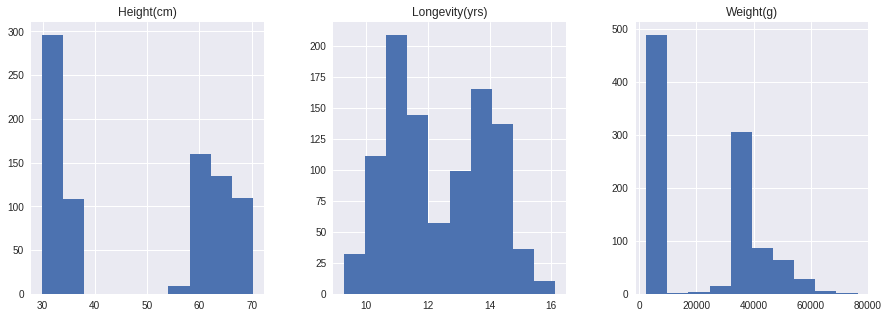

In [0]:
# Histograms for numerical data.
_ = df[numerical_columns].hist(
    bins=10, figsize=(15,5), 
    layout=(1, len(numerical_columns)))

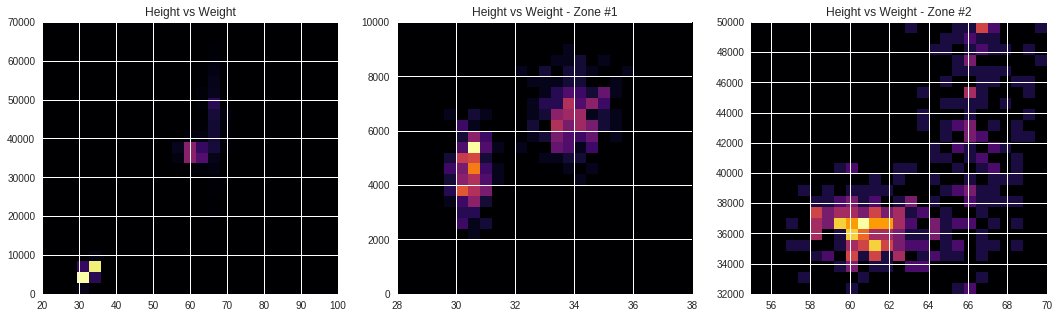

In [0]:
# Heat map of weight vs height.
df2 = df.dropna()
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title('Height vs Weight')
_ = plt.hist2d(df2['Height(cm)'], df2['Weight(g)'], bins=25, 
               cmap='inferno', range=[[20, 100], [0, 70000]])
plt.subplot(1, 3, 2)
plt.title('Height vs Weight - Zone #1')
_ = plt.hist2d(df2['Height(cm)'], df2['Weight(g)'], bins=25, 
               cmap='inferno', range=[[28, 38], [0, 10000]])
plt.subplot(1, 3, 3)
plt.title('Height vs Weight - Zone #2')
_ = plt.hist2d(df2['Height(cm)'], df2['Weight(g)'], bins=25, 
               cmap='inferno', range=[[55, 70], [32000, 50000]])

# Feature extraction

We will extract our features from the Pandas Dataframe. We will use one-hot encoding for the categorical features, and leave the numerical features as-is. We populate the missing features using the mean. We standardize each feature to have mean 0 and variance 1, in order not to give a disadvantages to models that are sensitive to data scaling.

## Useless features

We discard the feature `"Owner name"`, as it has little correlation with the data that we're trying to predict, and it would add a lot of dimensionality to the data, which is not ideal.

## Missing values

One of the features (namely `"Height(cm)"`) has some missing values. Our models cannot handle partial data, therefore we will input the **mean** of the respective feature for the missing records.

## Syntetic features

We will add two types of syntetic features: 
- **rational features: ** the weight/height feature
- **automatic features: ** features learned automatically by a Mixture of Gaussians model; the reason behind using this model to compute the features is that the continuous features are not normally-distributed, but rather seem to be _multimodal_ (this can be seen from the heat maps above)

## Code

In [0]:
def extract_features(df, use_extra):
  from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
  from sklearn.mixture import GaussianMixture
  from sklearn.model_selection import train_test_split

  # Fill the missing values with mean.
  df = df.fillna(df.mean(), inplace=False)
  
  # Get the categorical features.
  used_categorical_columns = list(set(categorical_columns) - \
      {'Breed Name', 'Owner Name'})
  X_cat_str = df[used_categorical_columns].values
  
  # Encode as one-hot.
  X_cat = np.zeros(X_cat_str.shape)
  for i in range(X_cat_str.shape[1]):
    X_cat[:, i] = LabelEncoder().fit_transform(X_cat_str[:, i])
  X_cat_one_hot = OneHotEncoder(sparse=False).fit_transform(X_cat)
  
  # Get the numerical values.
  used_numerical_columns = \
      list((set(numerical_columns)) - {'Longevity(yrs)'})
  X_num = df[used_numerical_columns].values
  
  
  # Concatenate the categorical features and the numerical ones
  # to obtain the dataset.
  X = np.hstack((X_num, X_cat_one_hot))
    
  # Get the labels.
  y_cat = LabelEncoder().fit_transform(df['Breed Name'].values)
  y_cat_one_hot = OneHotEncoder(sparse=False).fit_transform(
      y_cat.reshape((-1, 1)))
  y_num = df['Longevity(yrs)'].values
  
  # Split data into train/test.
  X_train, X_test, y_cat_train, y_cat_test, y_num_train, y_num_test = \
    train_test_split(X, y_cat, y_num, test_size=0.2, random_state=0)
  
  
  # Standardize the data.
  # We should only use training data for fitting the scaler.
  scaler = StandardScaler(copy=False)
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  
  if use_extra:
    # We should only use training data for fitting GMM.
    gm = GaussianMixture(n_components=4)
    gm.fit(X_train[:, :2])
    
    def add_extra(X):
      X_gm = gm.predict_proba(X[:, :2])
      X_ratio = (X[:, [0]] / X[:, [1]])
      return np.hstack((X, X_gm, X_ratio))
    
    X_train = add_extra(X_train)
    X_test = add_extra(X_test)
    
  return X_train, y_cat_train, y_num_train, X_test, y_cat_test, y_num_test

# Evaluation setup

We will use a combination of train-test split and cross validation to train our models, because the data is scarce. We will split the dataset into training and testing, and apply K-fold cross-validation on the training data in order to estimate the accuracy of the model. 

It is important to make sure that no model will benefit from "random luck" by setting a fixed random seed (i.e. `random_state=0`) for the K-fold.



In [0]:
def evaluate_model(model, X, y, metric):
  from sklearn.model_selection import KFold
  
  kf = KFold(n_splits=10, random_state=0)
  metrics = []
  
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics.append(metric(y_test, y_pred))
    
  return np.array(metrics)

## Setting up an evaluation config

In order for the comparison to make sense, all models have to be evaluated using the same metrics, and the same training procedure.

** For classification: ** The classes are (more or less) balanced within the dataset, as seen from the histograms above, so accuracy score is a good enough metric to evaluate.

In [0]:
def evaluate_classifier(model, use_extra=True):
  X_train, y_train, _, _, _, _ = extract_features(df, use_extra=use_extra)
  scores = evaluate_model(model, X_train, y_train, 
                          sk.metrics.accuracy_score)
  return np.mean(scores)

def test_classifier(model, use_extra=True):
  X_train, y_train, _, X_test, y_test, _ = extract_features(df, use_extra)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return sk.metrics.accuracy_score(y_test, y_pred)

** For regression: ** The R2 score is chosen to be most appropiate metric for the task at hand.

In [0]:
def evaluate_regressor(model, use_extra=True):
  X, _, y, _, _, _ = extract_features(df, use_extra)
  scores = evaluate_model(model, X, y, sk.metrics.r2_score)
  return np.mean(scores)

def test_regressor(model, use_extra=True):
  X_train, _, y_train, X_test, _, y_test = extract_features(df, use_extra)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return sk.metrics.r2_score(y_test, y_pred)

## Plotting

We will provide different visualisations during the comparison, including decision functions, bar charts, and so on.

In [0]:
def plot_scores_bar(models_dict, evaluate_fn, 
                    title=None, normalize=True):
  names = models_dict.keys()
  models = models_dict.values()
  y_pos = np.arange(len(models))
  scores = [evaluate_fn(model) for model in models]
  # Range normalize (sort of) to better see the differences.
  bottom = 0
  score_range = np.max(scores) - np.min(scores)
  if normalize and score_range != 0:
    bottom = np.min(scores) - 0.1 * score_range
    scores -= bottom
  
  plt.bar(y_pos, scores, align='center', bottom=bottom)
  plt.xticks(y_pos, names)
  plt.ylabel('Score')
  plt.xlabel('Model')
  if title:
    plt.title(title)
    

# Evaluating & comparing classifiers

The models that we will be comparing are _Logistic Regression_, _Random Forests_, and _K-Nearest Neighbors_

## Logistic regression

The hyperparameters that we will tune for LR are the regularization strength, and the penalty function (L1 or L2).

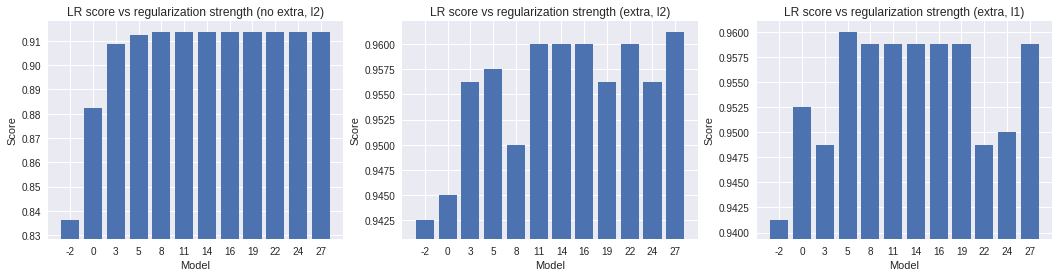

In [0]:
def plot_lr_bars():
  plt.figure(figsize=(18, 4))
  
  # Different configurations for C
  plt.subplot(131)
  models = {int(np.log(C)): LogisticRegression(C=C, tol=1e-3)
            for C in np.logspace(-1, 12, num=12)}
  plot_scores_bar(models, lambda x: evaluate_classifier(
                            x, use_extra=False), 
                  title='LR score vs regularization strength (no extra, l2)')
  
  # Different configurations for C
  plt.subplot(132)
  models = {int(np.log(C)): LogisticRegression(C=C, tol=1e-3)
            for C in np.logspace(-1, 12, num=12)}
  plot_scores_bar(models, lambda x: evaluate_classifier(
                            x, use_extra=True), 
                  title='LR score vs regularization strength (extra, l2)')
  
  # Different configurations for C
  plt.subplot(133)
  models = {int(np.log(C)): LogisticRegression(penalty='l1', C=C, tol=1e-3)
            for C in np.logspace(-1, 12, num=12)}
  plot_scores_bar(models, lambda x: evaluate_classifier(x, use_extra=True), 
                  title='LR score vs regularization strength (extra, l1)')
  
plot_lr_bars()

## Random forests

The hyperparameters that we will tune for RF are number of estimators, the maximum depth, and the maximum features.

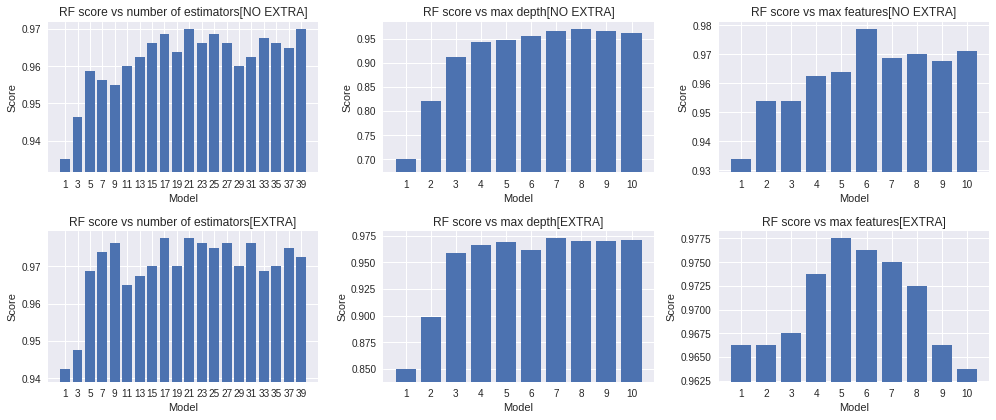

In [0]:
def plot_rf_bars():
  plt.figure(figsize=(14, 6))
  
  for idx, use_extra in enumerate([False, True]):
    def evaluate(x):
      return evaluate_classifier(x, use_extra=use_extra)
    def put_title(x):
      if use_extra:
        return x + "[EXTRA]"
      return x + "[NO EXTRA]"
    
    # Different configurations for n_estimators
    plt.subplot(2, 3, idx * 3 + 1)
    models = {n_estimators: RandomForestClassifier(
                n_estimators=n_estimators)
              for n_estimators in range(1, 41, 2)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('RF score vs number of estimators'))
    # Different configurations for max_depth
    plt.subplot(2, 3, idx * 3 + 2)
    models = {max_depth: RandomForestClassifier(
                max_depth=max_depth)
              for max_depth in range(1, 11, 1)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('RF score vs max depth'))
    # Different configurations for max_features.
    plt.subplot(2, 3, idx * 3 + 3)
    models = {max_features: RandomForestClassifier(
                max_features=max_features)
              for max_features in range(1, 11, 1)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('RF score vs max features'))
  plt.tight_layout()
  
plot_rf_bars()

## K-Nearest Neighbors

The important hyperparameters of KNN are the number of neighbors, the distance metric, and the weighting of the points (inverse-distance or uniform).

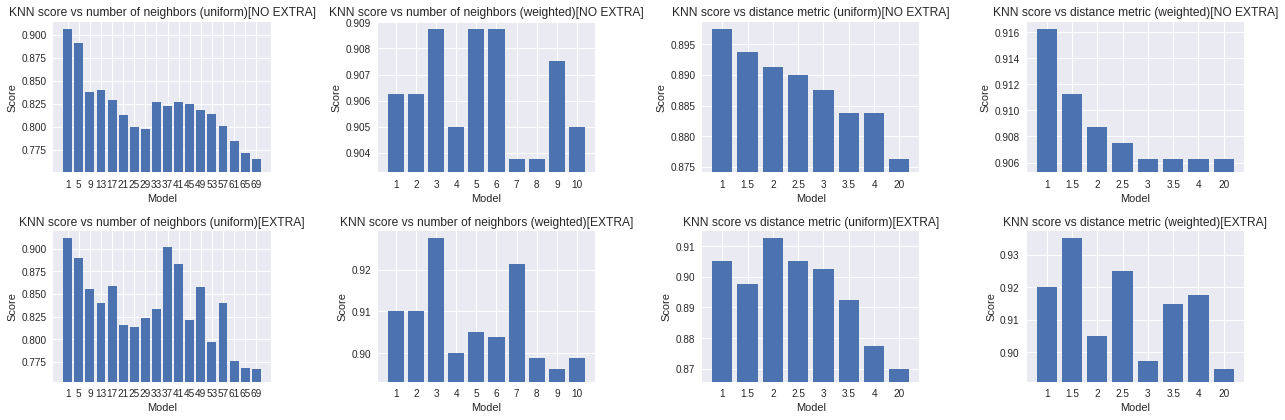

In [0]:
def plot_knn_bars():
  plt.figure(figsize=(18, 6))
  
  for idx, use_extra in enumerate([False, True]):
    def evaluate(x):
      return evaluate_classifier(x, use_extra=use_extra)
    def put_title(x):
      if use_extra:
        return x + "[EXTRA]"
      return x + "[NO EXTRA]"
    
    # Different configurations for n_neighbors
    plt.subplot(2, 4, idx * 4 + 1)
    models = {n_neighbors: KNeighborsClassifier(
                n_neighbors=n_neighbors)
              for n_neighbors in range(1, 71, 4)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs number of neighbors (uniform)'))
    # Different configurations for n_neighbors
    plt.subplot(2, 4, idx * 4 + 2)
    models = {n_neighbors: KNeighborsClassifier(
                n_neighbors=n_neighbors,
                weights='distance')
              for n_neighbors in range(1, 11, 1)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs number of neighbors (weighted)'))
    # Different configurations for p.
    plt.subplot(2, 4, idx * 4 + 3)
    models = {p: KNeighborsClassifier(p=p)
              for p in [1, 1.5, 2, 2.5, 3, 3.5, 4, 20]}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs distance metric (uniform)'))
    # Different configurations for p.
    plt.subplot(2, 4, idx * 4 + 4)
    models = {p: KNeighborsClassifier(p=p, weights='distance')
              for p in [1, 1.5, 2, 2.5, 3, 3.5, 4, 20]}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs distance metric (weighted)'))
  plt.tight_layout()
  
plot_knn_bars()
  

## Keeping the best

We will store in this models dict the best classifiers that we have found on the analysis above.

** Bonus: ** We add an ensemble classifier, that combines all the best classifiers and classifies based on weighted soft-voting. The weights of the classifiers inside the voting classifier are proportional to the scores on the training data.

Final scores:
LR: 0.93000
RF: 0.96500
KNN: 0.90500
STK: 0.93500


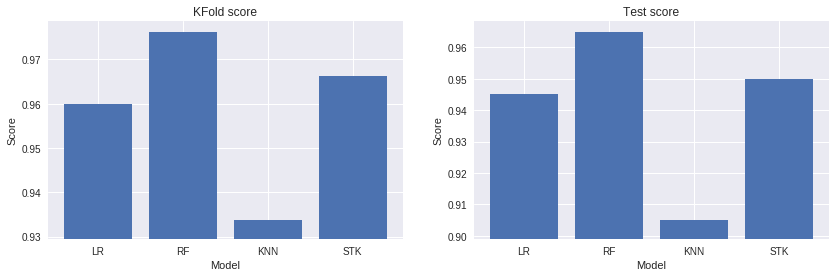

In [0]:
def get_classifiers_dict():
  return {
    'LR': LogisticRegression(C=np.exp(11), random_state=0),
    'RF': RandomForestClassifier(n_estimators=21, max_depth=7, max_features=5, 
                                 random_state=0, n_jobs=1),
    'KNN': KNeighborsClassifier(n_neighbors=3, p=1.5, weights='distance'),
  }

def compare_classifiers():
  def test(x): 
    return test_classifier(x, use_extra=True)
  def evaluate(x):
    return evaluate_classifier(x, use_extra=True)
  
  classifiers_dict = get_classifiers_dict()
  
  # Add a stacking classifier.
  scores = list(map(evaluate, classifiers_dict.values()))
  classifiers_dict['STK'] = VotingClassifier(
      estimators=list(classifiers_dict.items()), 
      voting='soft', weights=scores, n_jobs=1)
  
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plot_scores_bar(classifiers_dict, evaluate, title='KFold score')
  plt.subplot(1, 2, 2)
  plot_scores_bar(classifiers_dict, test, title='Test score')
  
  final_scores = list(map(test, classifiers_dict.values()))
  print('Final scores:')
  for clf, score in zip(classifiers_dict.keys(), final_scores):
    print('{0}: {1:.5f}'.format(clf, score))
  
# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')
compare_classifiers()

# Evaluating & comparing regressors

The models that we will be comparing are _Linear Regression_, and _K-Nearest Neighbors Regression_

## Linear regression

The hyperparameters that we will tune for LR are the regularization strength, and the penalty function (L1 - lasso regression or L2 - ridge regression).

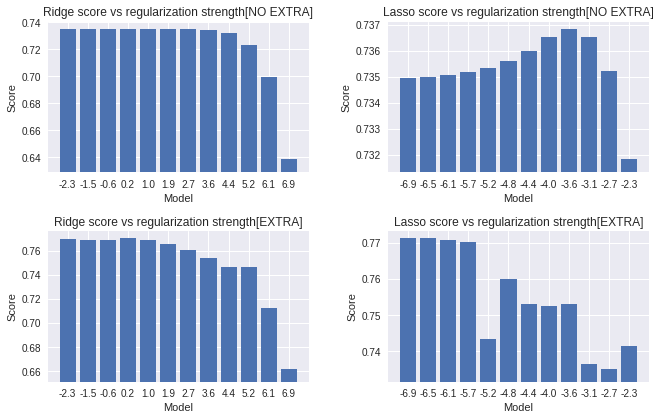

In [0]:
def plot_lr_bars():
  
  plt.figure(figsize=(14, 6))
  
  for idx, use_extra in enumerate([False, True]):
    def evaluate(x):
      return evaluate_regressor(x, use_extra=use_extra)
    def put_title(x):
      if use_extra:
        return x + "[EXTRA]"
      return x + "[NO EXTRA]"
    
    # Different configurations for alpha
    plt.subplot(2, 3, 3 * idx + 1)
    models = {round(np.log(alpha), 1): Ridge(alpha=alpha, tol=1e-3)
              for alpha in np.logspace(-1, 3, num=12)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('Ridge score vs regularization strength'))
    
    # Different configurations for alpha
    plt.subplot(2, 3, 3 * idx + 2)
    models = {round(np.log(alpha), 1): Lasso(alpha=alpha, tol=1e-3)
              for alpha in np.logspace(-3, -1, num=12)}
    plot_scores_bar(models, evaluate,
                    title=put_title('Lasso score vs regularization strength')) 

    
  plt.tight_layout()
  
plot_lr_bars()

## K-Nearest Neighbors Regression

The important hyperparameters of KNN are the number of neighbors, the distance metric, and the weighting of the points (inverse-distance or uniform).

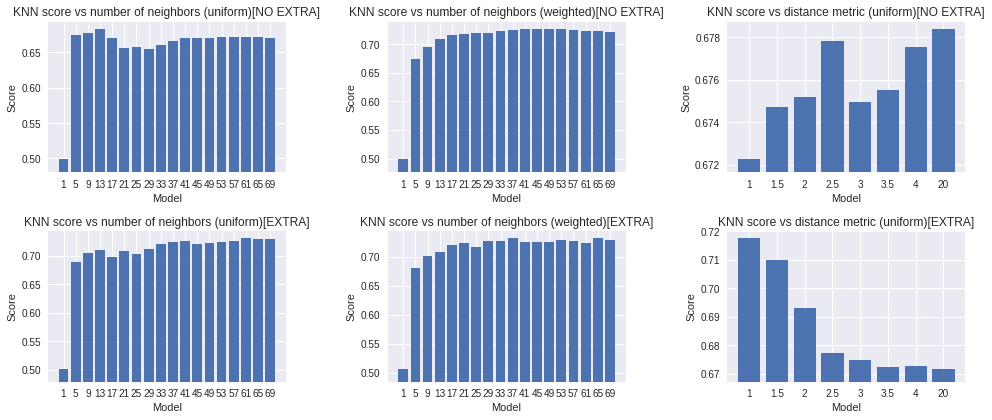

In [0]:
def plot_knn_bars():
  plt.figure(figsize=(14, 6))
  
  for idx, use_extra in enumerate([False, True]):
    def evaluate(x):
      return evaluate_regressor(x, use_extra=use_extra)
    def put_title(x):
      if use_extra:
        return x + "[EXTRA]"
      return x + "[NO EXTRA]"
    
    # Different configurations for n_neighbors.
    plt.subplot(2, 3, idx * 3 + 1)
    models = {n_neighbors: KNeighborsRegressor(
                n_neighbors=n_neighbors)
              for n_neighbors in range(1, 71, 4)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs number of neighbors (uniform)'))
    # Different configurations for n_neighbors.
    plt.subplot(2, 3, idx * 3 + 2)
    models = {n_neighbors: KNeighborsRegressor(
                n_neighbors=n_neighbors,
                weights='distance')
              for n_neighbors in range(1, 71, 4)}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs number of neighbors (weighted)'))
    # Different configurations for p.
    plt.subplot(2, 3, idx * 3 + 3)
    models = {p: KNeighborsRegressor(p=p)
              for p in [1, 1.5, 2, 2.5, 3, 3.5, 4, 20]}
    plot_scores_bar(models, evaluate, 
                    title=put_title('KNN score vs distance metric (uniform)'))
  plt.tight_layout()
  
plot_knn_bars()
  

## Keeping the best

We will store in this models dict the best regressor that we have found on the analysis above.

Final scores:
LINEAR: 0.72682
RIDGE: 0.73294
LASSO: 0.76245
KNN: 0.73281


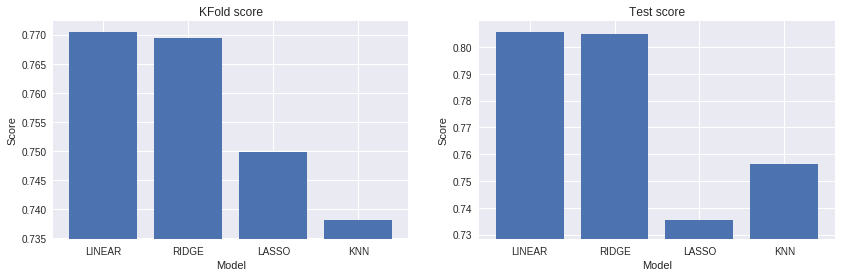

In [0]:
def get_regressors_dict():
  return {
    'LINEAR': LinearRegression(),
    'RIDGE': Ridge(alpha=np.exp(-.6)),
    'LASSO': Lasso(alpha=np.exp(-3)),
    'KNN': KNeighborsRegressor(p=1.5, n_neighbors=70),
  }

def compare_regressors():
  def test(x): 
    return test_regressor(x, use_extra=True)
  def evaluate(x):
    return evaluate_regressor(x, use_extra=True)
  
  regressors_dict = get_regressors_dict()
  
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plot_scores_bar(regressors_dict, evaluate, title='KFold score')
  plt.subplot(1, 2, 2)
  plot_scores_bar(regressors_dict, test, title='Test score')
  
  final_scores = list(map(test, regressors_dict.values()))
  print('Final scores:')
  for clf, score in zip(regressors_dict.keys(), final_scores):
    print('{0}: {1:.5f}'.format(clf, score))
  
# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')
compare_regressors()

## Visualizing regression curves

We will use PCA to extract two one-dimensional subspaces in order to visualize the regression line, along with the data.

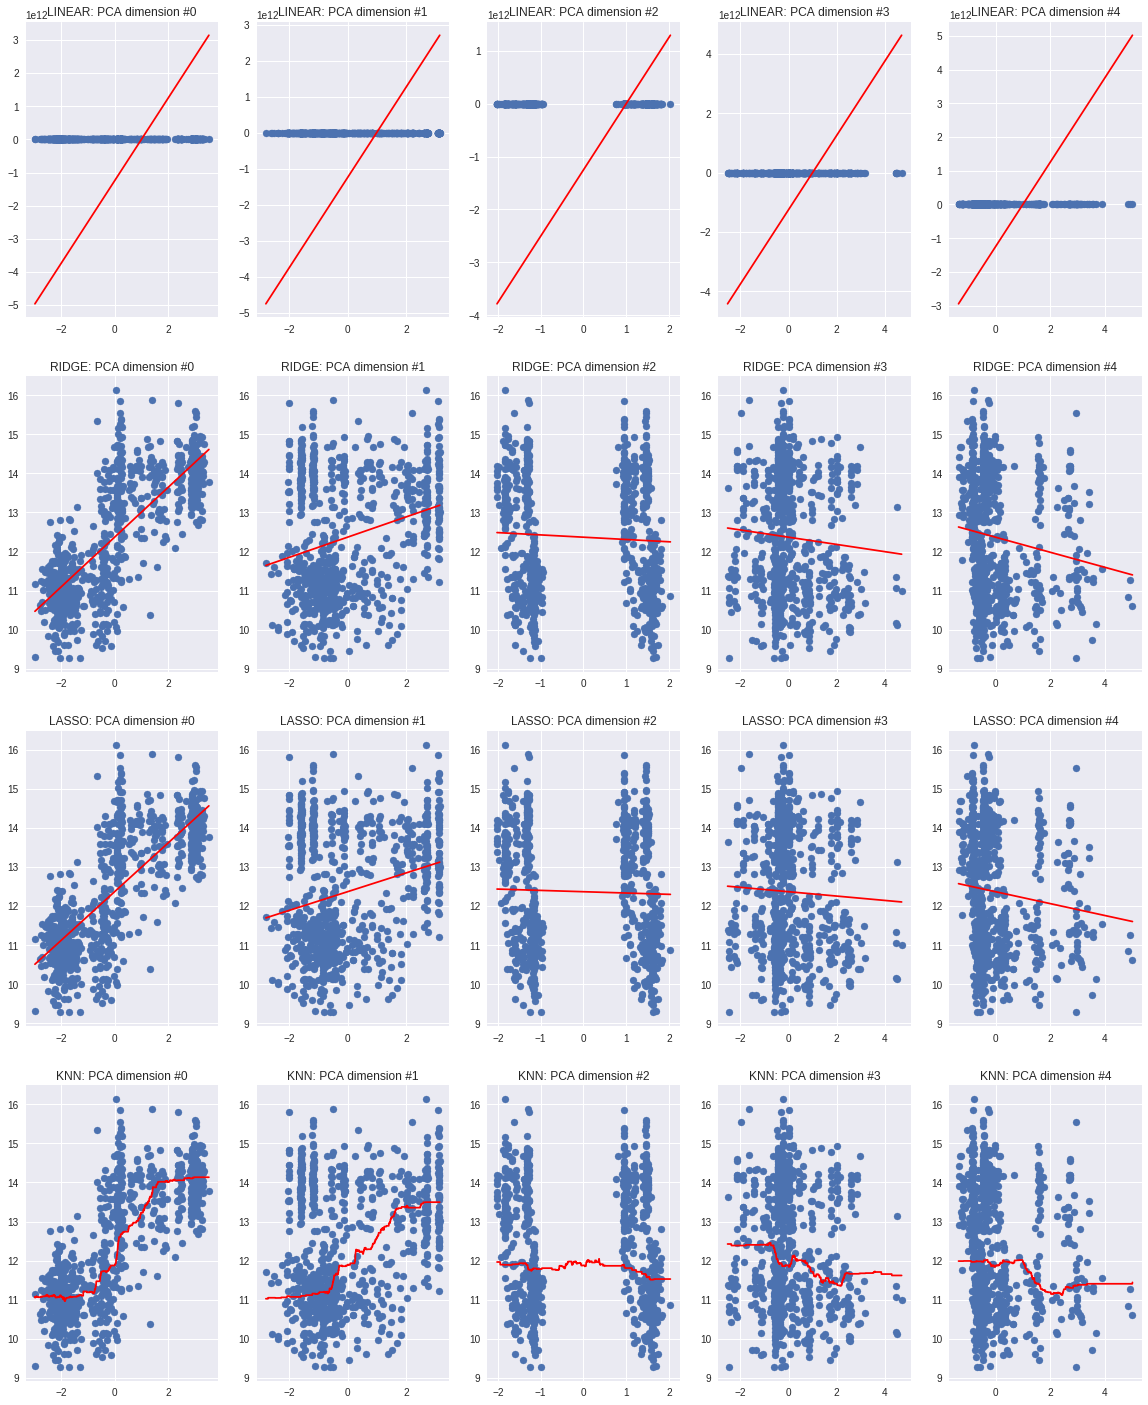

In [0]:
PCA_DIM = 5

def plot_models(model_dict):
  
  X, _, y, _, _, _ = extract_features(df, use_extra=True)
  
  plt.figure(figsize=(5*len(model_dict), 5*PCA_DIM))
  
  for idx, (name, model) in enumerate(model_dict.items()):
    model.fit(X, y)
    pca = sk.decomposition.PCA(PCA_DIM)
    X = pca.fit_transform(X)
    
    for dim in range(PCA_DIM):
      plt.subplot(len(model_dict), PCA_DIM, PCA_DIM * idx + dim + 1)
      # Get the projections for the specific dimension (as indices).
      x = X[:, dim]
      # Get the principal vector.
      principal_vector = pca.inverse_transform(np.eye(PCA_DIM)[[dim], :])
      # Get the Xs corresponding to a linspace in the projected dimension.
      xs = np.linspace(np.min(x), np.max(x), 1000)
      ys = model.predict(np.dot(xs.reshape(-1, 1), principal_vector))
      
      plt.scatter(x, y)
      xs = np.linspace(np.min(x), np.max(x), 1000)
      plt.plot(xs, ys, 'r-')
      plt.title('{}: PCA dimension #{}'.format(name, dim))
  
plot_models(get_regressors_dict())